In [55]:
import pandas as pd

import sys
print(sys.version)
sys.path.append('../../')
sys.path.append('../')
sys.path.append('../../../')


from drive.model_training.data_utils.extractors import * 
from drive.model_training.data_utils.animate_time_constant import * 
from first_order_model import *

from drive.util.model_func import *
from drive.util.transform_algebra import *



import matplotlib.animation as animation
from matplotlib.backend_bases import KeyEvent

import tqdm
import pickle

from matplotlib.backends.backend_pdf import PdfPages



3.10.12 (main, Jul 19 2024, 11:05:56) [GCC 11.4.0]


In [56]:
path_to_dataset = "/home/nicolassamson/ros2_ws/src/DRIVE/drive_datasets/data/warthog/wheels/asphalt/warthog_wheels_asphalt_2024_9_20_8h21s48/model_training_datasets/slip_dataset_all.pkl"


df = pd.read_pickle(path_to_dataset)

print_column_unique_column(df)


imu_acceleration_x = column_type_extractor(df,"imu_acceleration_x",verbose=False,steady_state=False)

imu_acceleration_x_transient = column_type_extractor(df,"imu_acceleration_x",verbose=False,steady_state=True)


steady_state_path = "/home/nicolassamson/ros2_ws/src/DRIVE/drive_datasets/data/warthog/wheels/asphalt/warthog_wheels_asphalt_2024_9_20_8h21s48/model_training_datasets/steady_state_results.pkl"

df_diamond = pd.read_pickle(steady_state_path)
df_diamond.columns





Index(['terrain', 'robot', 'traction', 'cmd_left_wheels', 'cmd_right_wheels',
       'cmd_body_x', 'cmd_body_yaw', 'icp_vel_x_smoothed',
       'icp_vel_yaw_smoothed', 'odom_speed_left_wheels',
       'odom_speed_right_wheels', 'slip_body_x_ss', 'slip_body_yaw_ss',
       'slip_body_y_ss', 'slip_wheel_left_ss', 'slip_wheel_right_ss',
       'left_wheel_vel_gains', 'left_wheel_vel_time_constants',
       'left_wheel_vel_time_delay',
       'left_wheel_vel_time_constant_problematic_computation',
       'left_wheel_vel_time_delay_problematic_computation',
       'left_wheel_vel_valid_mask_tc', 'left_wheel_vel_operation_points',
       'left_wheel_vel_steps', 'right_wheel_vel_gains',
       'right_wheel_vel_time_constants', 'right_wheel_vel_time_delay',
       'right_wheel_vel_time_constant_problematic_computation',
       'right_wheel_vel_time_delay_problematic_computation',
       'right_wheel_vel_valid_mask_tc', 'right_wheel_vel_operation_points',
       'right_wheel_vel_steps', 'icp_ve

In [57]:
list_names = ['terrain', 'robot', 'traction', 'cmd_left_wheels', 'cmd_right_wheels',
       'cmd_body_x', 'cmd_body_yaw', 'icp_vel_x_smoothed',
       'icp_vel_yaw_smoothed', 'odom_speed_left_wheels',
       'odom_speed_right_wheels', 'slip_body_x_ss', 'slip_body_yaw_ss',
       'slip_body_y_ss', 'slip_wheel_left_ss', 'slip_wheel_right_ss',
       'left_wheel_vel_gains', 'left_wheel_vel_time_constants',
       'left_wheel_vel_time_delay',
       'left_wheel_vel_time_constant_problematic_computation',
       'left_wheel_vel_time_delay_problematic_computation',
       'left_wheel_vel_valid_mask_tc', 'left_wheel_vel_operation_points',
       'left_wheel_vel_steps', 'right_wheel_vel_gains',
       'right_wheel_vel_time_constants', 'right_wheel_vel_time_delay',
       'right_wheel_vel_time_constant_problematic_computation',
       'right_wheel_vel_time_delay_problematic_computation',
       'right_wheel_vel_valid_mask_tc', 'right_wheel_vel_operation_points',
       'right_wheel_vel_steps', 'icp_vel_x_gains', 'icp_vel_x_time_constants',
       'icp_vel_x_time_delay',
       'icp_vel_x_time_constant_problematic_computation',
       'icp_vel_x_time_delay_problematic_computation',
       'icp_vel_x_valid_mask_tc', 'icp_vel_x_operation_points',
       'icp_vel_x_steps', 'icp_vel_yaw_gains', 'icp_vel_yaw_time_constants',
       'icp_vel_yaw_time_delay',
       'icp_vel_yaw_time_constant_problematic_computation',
       'icp_vel_yaw_time_delay_problematic_computation',
       'icp_vel_yaw_valid_mask_tc', 'icp_vel_yaw_operation_points',
       'icp_vel_yaw_steps', 'icp_vel_y_gains', 'icp_vel_y_time_constants',
       'icp_vel_y_time_delay',
       'icp_vel_y_time_constant_problematic_computation',
       'icp_vel_y_time_delay_problematic_computation',
       'icp_vel_y_valid_mask_tc', 'icp_vel_y_operation_points',
       'icp_vel_y_steps']

for names in list_names:
    if "gain" in names :
        print(names)

left_wheel_vel_gains
right_wheel_vel_gains
icp_vel_x_gains
icp_vel_yaw_gains
icp_vel_y_gains


In [58]:


def plot_histogramme(ax,df,column_of_interest,transient_only_flag=True,nb_bins=30,range=(0,0)):


    if transient_only_flag:
        imu_acceleration_x = column_type_extractor(df,column_of_interest,verbose=False,steady_state=False)
        labels_y = column_of_interest+"\n transient_state"
    
    else:
        imu_acceleration_x= column_type_extractor(df,column_of_interest,verbose=False,steady_state=True)
        labels_y = column_of_interest

    
    if range == (0,0):
            ax.hist(imu_acceleration_x,bins=nb_bins)
    else:
            ax.hist(imu_acceleration_x,bins=nb_bins,range=range)


    
    ax.set_xlabel(labels_y)
    
def global_y_axis(axs):
    
    flatten_axs = np.ravel(axs)
    
    min = 0 
    max = 0
    for ax in flatten_axs:
        if ax.get_ylim()[1]> max:
            max =  ax.get_ylim()[1]

    for ax in flatten_axs:
        ax.set_ylim(min,max)


def plot_all(df,list_of_column_of_interest,nb_bins=25,range=(0,0)):

    fig, axs = plt.subplots(1,3)
    fig.set_figwidth(3*len(list_of_column_of_interest))
    
    for ax,column_of_interest in zip(axs,list_of_column_of_interest):

        plot_histogramme(ax,df,column_of_interest,nb_bins=nb_bins,range=range)


    global_y_axis(axs)

    return fig

def plot_diamond_hist(df, list_of_column_of_interest,nb_bins=25, range=(0,0)): 
    test = ["icp_vel_x_gains","icp_vel_y_gains","icp_vel_yaw_gains","left_wheel_vel_gains","right_wheel_vel_gains"]
    fig, axs = plt.subplots(1,len(list_of_column_of_interest))
    df = df
    fig.set_figwidth(3*len(axs))

    for i,column_of_interest in enumerate(list_of_column_of_interest):

        if range == (0,0):
            axs[i].hist(df[list_of_column_of_interest[i]],bins=nb_bins)
            
        else:
            axs[i].hist(df[list_of_column_of_interest[i]],bins=nb_bins,range=range)



        axs[i].set_xlabel(column_of_interest)
    global_y_axis(axs)

    return fig

In [59]:
# Descriptions 

def plot_acceleration_histogramme(df,nb_bins=30,range=(0,0)):
    

    list_of_column_of_interest = ["imu_acceleration_x","imu_acceleration_y","imu_yaw"]
    df = df
    
    fig, axs = plt.subplots(1,3)
    fig.set_figwidth(3*len(list_of_column_of_interest))
    

    plot_all(axs,df,list_of_column_of_interest,nb_bins=30,range=range)


def plot_slip_histogramme(df,nb_bins=30,range=(0,0)):
    fig, axs = plt.subplots(1,3)

    list_of_column_of_interest = ["body_vel_disturption_x","body_vel_disturption_y","body_vel_disturption_yaw"]
    df = df
    fig.set_figwidth(3*len(axs))

    plot_all(axs,df,list_of_column_of_interest,nb_bins=nb_bins,range=range)

def plot_steps_histogramme(df,nb_bins=30,range=(0,0)):

    fig, axs = plt.subplots(1,3)

    list_of_column_of_interest = ["icp_vel_x_steps","icp_vel_y_steps","icp_vel_yaw_steps"]
    df = df
    fig.set_figwidth(3*len(axs))

    for i,column_of_interest in enumerate(list_of_column_of_interest):
        if range == (0,0):
            axs[i].hist(df[list_of_column_of_interest[i]],bins=nb_bins)
            axs[i].set_xlabel(column_of_interest)
        else:
            axs[i].hist(df[list_of_column_of_interest[i]],bins=nb_bins,range=range)
    
        axs[i].set_xlabel(column_of_interest)
    
    global_y_axis(axs)
def plot_operation_histogramme(df,nb_bins=30,range=(0,0)):

    fig, axs = plt.subplots(1,3)

    list_of_column_of_interest = ["icp_vel_x_operation_points","icp_vel_y_operation_points","icp_vel_yaw_operation_points"]
    df = df
    fig.set_figwidth(3*len(axs))

    for i,column_of_interest in enumerate(list_of_column_of_interest):
        if range == (0,0):
            axs[i].hist(df[list_of_column_of_interest[i]],bins=nb_bins)
            axs[i].set_xlabel(column_of_interest)
        else:
            axs[i].hist(df[list_of_column_of_interest[i]],bins=nb_bins,range=range)

        axs[i].set_xlabel(column_of_interest)
    global_y_axis(axs)
def plot_time_constant(df,nb_bins=30,range=(0,0)):

    fig, axs = plt.subplots(1,5)

    list_of_column_of_interest = ["icp_vel_x_time_constants","icp_vel_y_time_constants","icp_vel_yaw_time_constants","left_wheel_vel_time_constants","right_wheel_vel_time_constants"]
    df = df
    fig.set_figwidth(3*len(axs))

    for i,column_of_interest in enumerate(list_of_column_of_interest):
        if range == (0,0):
            axs[i].hist(df[list_of_column_of_interest[i]],bins=nb_bins)
            
        else:
            axs[i].hist(df[list_of_column_of_interest[i]],bins=nb_bins,range=range)

        axs[i].set_xlabel(column_of_interest)
    global_y_axis(axs)
        
def plot_proportionnal_slip(df,nb_bins=30,range=(0,0),name=""):

    

    list_of_column_of_interest = ["icp_vel_x_gains","icp_vel_y_gains","icp_vel_yaw_gains","left_wheel_vel_gains","right_wheel_vel_gains"]
    fig, axs = plt.subplots(1,len(list_of_column_of_interest))
    df = df
    fig.set_figwidth(3*len(axs))

    for i,column_of_interest in enumerate(list_of_column_of_interest):

        if range == (0,0):
            axs[i].hist(df[list_of_column_of_interest[i]],bins=nb_bins)
            
        else:
            axs[i].hist(df[list_of_column_of_interest[i]],bins=nb_bins,range=range)



        axs[i].set_xlabel(column_of_interest)
    global_y_axis(axs)

    # Save the figure using pickle
    #with open(name, 'wb') as f:
    #    pickle.dump(fig, f)

    



def plot_all_histogramme(df, df_diamond,path_to_results):

    name = "diamond_hist.pkl"

    list_fig = []
    list_of_column_of_interest = ["icp_vel_x_steps","icp_vel_y_steps","icp_vel_yaw_steps"]
    list_fig.append(plot_diamond_hist(df_diamond, list_of_column_of_interest,nb_bins=20,range= (-10,10)))

    list_of_column_of_interest = ["icp_vel_x_operation_points","icp_vel_y_operation_points","icp_vel_yaw_operation_points"]
    list_fig.append(plot_diamond_hist(df_diamond, list_of_column_of_interest,nb_bins=30,range= (-5,5)))

    list_of_column_of_interest = ["icp_vel_x_time_constants","icp_vel_y_time_constants","icp_vel_yaw_time_constants","left_wheel_vel_time_constants","right_wheel_vel_time_constants"]
    list_fig.append(plot_diamond_hist(df_diamond, list_of_column_of_interest,nb_bins=30, range=(0,6)))


    list_of_column_of_interest = ["icp_vel_x_gains","icp_vel_y_gains","icp_vel_yaw_gains","left_wheel_vel_gains","right_wheel_vel_gains"]
    list_fig.append(plot_diamond_hist(df_diamond, list_of_column_of_interest,nb_bins=30, range=(-5,5)))

    list_of_column_of_interest = ["imu_acceleration_x","imu_acceleration_y","imu_yaw"]
    list_fig.append(plot_all(df,list_of_column_of_interest,nb_bins=20,range=(-5,5)))

    list_of_column_of_interest = ["body_vel_disturption_x","body_vel_disturption_y","body_vel_disturption_yaw"]
    list_fig.append(plot_all(df,list_of_column_of_interest,nb_bins=30,range= (-5,5)))

    path_to_pdf = path_to_results/"histogramme_analysis.pdf"
    # Create a PDF file to save the figures
    with PdfPages(str(path_to_pdf)) as pdf:

        for figure in list_fig:
            pdf.savefig(figure)
            

    #plot_acceleration_histogramme(df)
    #plot_slip_histogramme(df,nb_bins=30,range= (-5,5))

    
    #plot_steps_histogramme(df_diamond,nb_bins=20,range= (-10,10))
    #plot_operation_histogramme(df_diamond,nb_bins=30,range= (-5,5))
    #plot_time_constant(df_diamond,nb_bins=30,range= (0,6))
    #plot_proportionnal_slip(df_diamond,nb_bins=30,range= (-5,5))



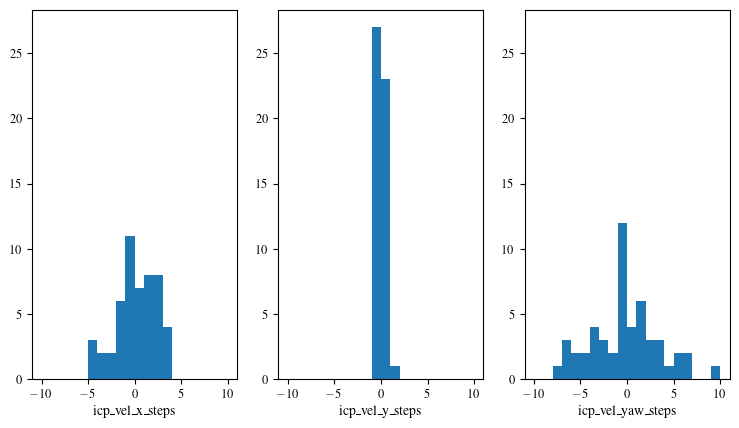

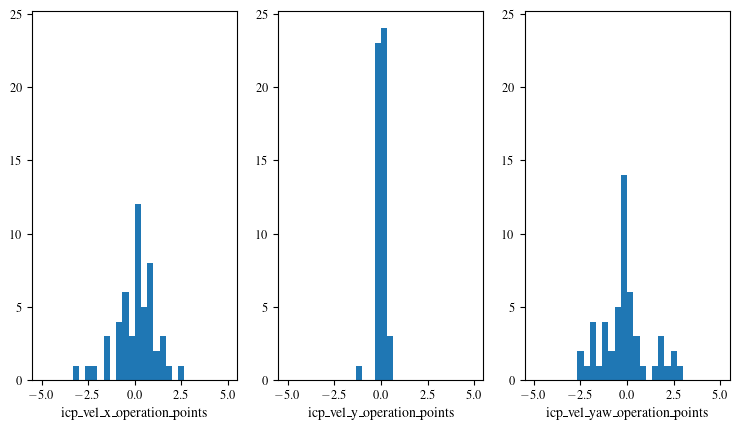

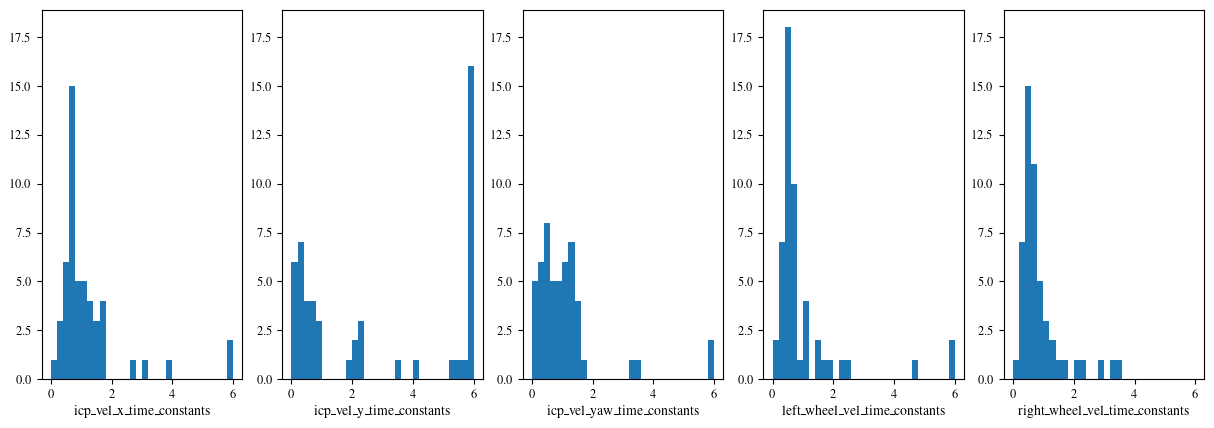

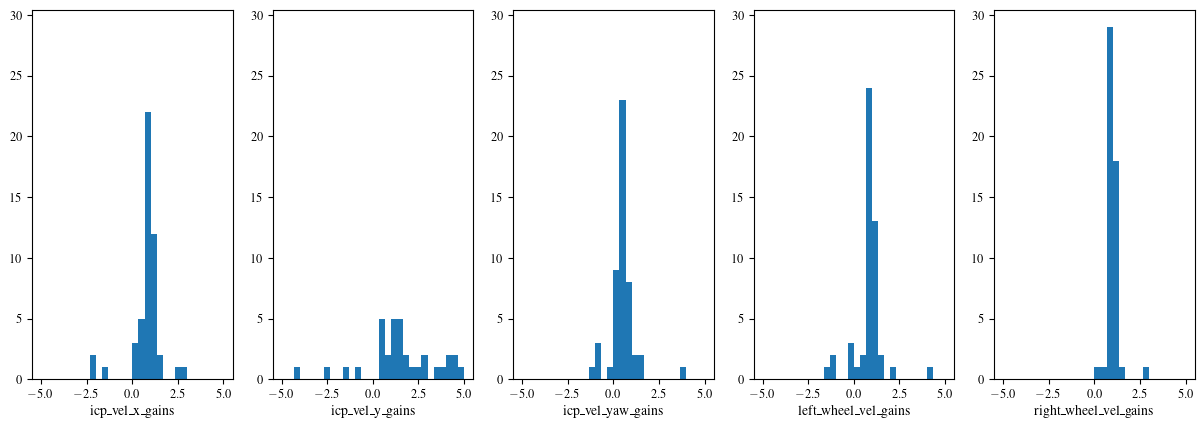

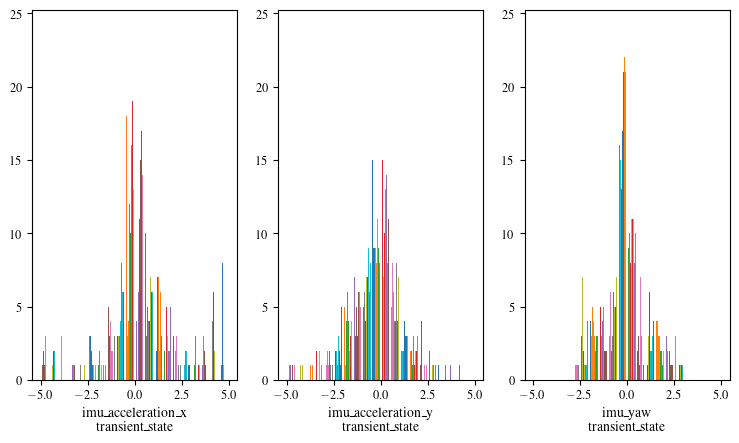

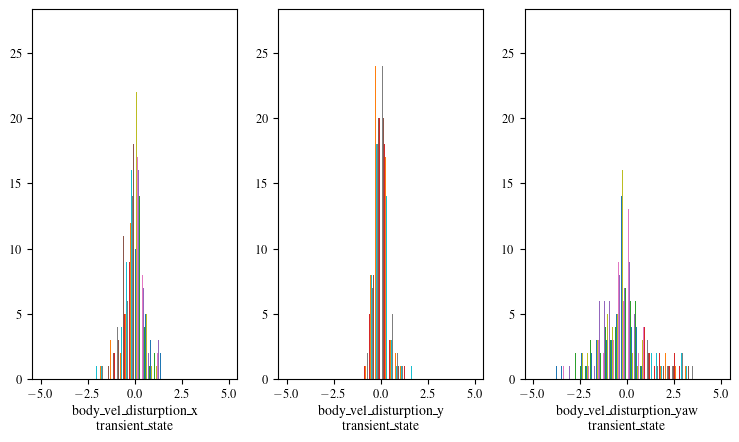

In [60]:
path_slip_dataset = pathlib.Path(path_to_dataset)
path_to_results = path_slip_dataset.parent.parent /"results"

if path_to_results.is_dir() == False:
    path_to_results.mkdir()

plot_all_histogramme(df, df_diamond,path_to_results)
